<center><img src="https://raw.githubusercontent.com/EO-College/cubes-and-clouds/main/icons/cnc_3icons_process_circle.svg"
     alt="Cubes & Clouds logo"
     style="float: center; margin-right: 10px; margin-left: 10px; max-height: 250px;" /></center>

# 3.1 Data Processing

<img src="https://openeo.org/images/openeo_logo.png"
     alt="openEO logo"
     style="float: center; margin-right: 10px; max-height: 100px;"/>

## Snow Cover mapping with openEO

In this exercise we will build a complete EO workflow on a cloud platform; from data access to obtaining the result. In this example we will analyse snow cover in the Alps.

We are going to follow these steps in our analysis:

-   Load satellite collections
-   Specify the spatial, temporal extents and the features we are interested in
-   Process the satellite data to retrieve snow cover information
-   Aggregate information to get catchment statistics over time
-   Visualize and analyse the results

More information on the openEO Python Client: https://open-eo.github.io/openeo-python-client/index.html

## Libraries

We start by creating the shared folders and data files needed to complete the exercise using the following shell commands

In [1]:
!cp -r ${DATA_PATH%/*/*}/notebooks/cubes-and-clouds/lectures/3.1_data_processing/exercises/31_results $HOME/
!cp -r ${DATA_PATH%/*/*}/notebooks/cubes-and-clouds/lectures/3.1_data_processing/exercises/31_data $HOME/

In [2]:
# platform libraries
import openeo

# utility libraries
from datetime import date
import numpy as np
import xarray as xr
import rioxarray
import json
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import leafmap.foliumap as leafmap

## Connect to a cloud platform
Connect to the Copernicus Dataspace Ecosystem. Being connected allows for data discovery.

In [3]:
conn = openeo.connect('https://openeo.dataspace.copernicus.eu/')

And login. Being logged in allows to use the full range of functionality including processing!

In [4]:
conn.authenticate_oidc()

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=HUUE-LPCV 📋 to authenticate.

✅ Authorized successfully

Authenticated using device code flow.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

Check if the login worked.

In [5]:
conn.describe_account()

{'info': {'oidc_userinfo': {'email': 'younkapingsead@gmail.com',
   'email_verified': True,
   'family_name': 'Duplex',
   'given_name': 'YOUNKAP NINA',
   'name': 'YOUNKAP NINA Duplex',
   'preferred_username': 'younkapingsead@gmail.com',
   'sub': '86b84b23-5c8b-4db0-ab03-d05137881fac'}},
 'name': 'YOUNKAP NINA Duplex',
 'user_id': '86b84b23-5c8b-4db0-ab03-d05137881fac'}

## Region of Interest

Our region of interest is the Val Passiria Catchment in the South Tyrolian Alps (Italy). Let's load the catchment area.

In [6]:
catchment_outline = gpd.read_file('31_data/catchment_outline.geojson')

In [7]:
center = (float(catchment_outline.centroid.y), float(catchment_outline.centroid.x))
m = leafmap.Map(center=center, zoom=10)
m.add_vector('31_data/catchment_outline.geojson', layer_name="catchment")
m

**Quiz hint: Look closely at the end of the displayed catchment area to identify the outlet**

## Inspect Metadata
We need to set the following configurations to define the content of the data cube we want to access:
- dataset name
- band names
- time range
- the area of interest specifed via bounding box coordinates
- spatial resolution

To select the correct dataset we can first list all the available datasets.

In [8]:
print(conn.list_collection_ids())

['SENTINEL3_OLCI_L1B', 'SENTINEL3_SLSTR', 'SENTINEL_5P_L2', 'COPERNICUS_VEGETATION_PHENOLOGY_PRODUCTIVITY_10M_SEASON1', 'COPERNICUS_VEGETATION_PHENOLOGY_PRODUCTIVITY_10M_SEASON2', 'COPERNICUS_PLANT_PHENOLOGY_INDEX', 'ESA_WORLDCOVER_10M_2020_V1', 'ESA_WORLDCOVER_10M_2021_V2', 'COPERNICUS_VEGETATION_INDICES', 'SENTINEL2_L1C', 'SENTINEL2_L2A', 'SENTINEL1_GRD', 'COPERNICUS_30', 'LANDSAT8_L2', 'SENTINEL3_SYN_L2_SYN', 'SENTINEL3_SLSTR_L2_LST', 'SENTINEL1_GLOBAL_MOSAICS', 'SENTINEL3_OLCI_L2_LAND', 'SENTINEL3_OLCI_L2_WATER', 'SENTINEL3_SYN_L2_AOD']


We want to use the Sentinel-2 L2A product. It's name is `'SENTINEL2_L2A'`. 

We get the metadata for this collection as follows. This is an important step to familiarize yourself with the data collection (e.g. learn the band names).

In [9]:
conn.describe_collection("SENTINEL2_L2A")

{'assets': {'thumbnail': {'href': 'https://www.esa.int/var/esa/storage/images/esa_multimedia/images/2022/07/tallinn_estonia/24383281-1-eng-GB/Tallinn_Estonia_pillars.jpg',
   'roles': ['thumbnail'],
   'title': 'Sentinel 2 L2A',
   'type': 'image/png'}},
 'cube:dimensions': {'bands': {'type': 'bands',
   'values': ['B01',
    'B02',
    'B03',
    'B04',
    'B05',
    'B06',
    'B07',
    'B08',
    'B8A',
    'B09',
    'B11',
    'B12',
    'WVP',
    'AOT',
    'SCL',
    'sunAzimuthAngles',
    'sunZenithAngles',
    'viewAzimuthMean',
    'viewZenithMean']},
  't': {'extent': ['2015-07-04T00:00:00Z', None], 'type': 'temporal'},
  'x': {'axis': 'x',
   'extent': [-180, 180],
   'reference_system': {'$schema': 'https://proj.org/schemas/v0.2/projjson.schema.json',
    'area': 'World',
    'bbox': {'east_longitude': 180,
     'north_latitude': 90,
     'south_latitude': -90,
     'west_longitude': -180},
    'coordinate_system': {'axis': [{'abbreviation': 'Lat',
       'direction': 'north',
       'name': 'Geodetic latitude',
       'unit': 'degree'},
      {'abbreviation': 'Lon',
       'direction': 'east',
       'name': 'Geodetic longitude',
       'unit': 'degree'}],
     'subtype': 'ellipsoidal'},
    'datum': {'ellipsoid': {'inverse_flattening': 298.257223563,
      'name': 'WGS 84',
      'semi_major_axis': 6378137},
     'name': 'World Geodetic System 1984',
     'type': 'GeodeticReferenceFrame'},
    'id': {'authority': 'OGC', 'code': 'Auto42001', 'version': '1.3'},
    'name': 'AUTO 42001 (Universal Transverse Mercator)',
    'type': 'GeodeticCRS'},
   'step': 10,
   'type': 'spatial'},
  'y': {'axis': 'y',
   'extent': [-56, 83],
   'reference_system': {'$schema': 'https://proj.org/schemas/v0.2/projjson.schema.json',
    'area': 'World',
    'bbox': {'east_longitude': 180,
     'north_latitude': 90,
     'south_latitude': -90,
     'west_longitude': -180},
    'coordinate_system': {'axis': [{'abbreviation': 'Lat',
       'direction': 'north',
       'name': 'Geodetic latitude',
       'unit': 'degree'},
      {'abbreviation': 'Lon',
       'direction': 'east',
       'name': 'Geodetic longitude',
       'unit': 'degree'}],
     'subtype': 'ellipsoidal'},
    'datum': {'ellipsoid': {'inverse_flattening': 298.257223563,
      'name': 'WGS 84',
      'semi_major_axis': 6378137},
     'name': 'World Geodetic System 1984',
     'type': 'GeodeticReferenceFrame'},
    'id': {'authority': 'OGC', 'code': 'Auto42001', 'version': '1.3'},
    'name': 'AUTO 42001 (Universal Transverse Mercator)',
    'type': 'GeodeticCRS'},
   'step': 10,
   'type': 'spatial'}},
 'description': 'SENTINEL-2 is a wide-swath, high-resolution, multi-spectral imaging mission, supporting Copernicus Land Monitoring studies, including the monitoring of vegetation, soil and water cover, as well as observation of inland waterways and coastal areas. The SENTINEL-2 Multispectral Instrument (MSI) samples 13 spectral bands: four bands at 10 metres, six bands at 20 metres and three bands at 60 metres spatial resolution.\n The level 2A data is atmospherically corrected using Sen2Cor.',
 'extent': {'spatial': {'bbox': [[-180, -56, 180, 83]]},
  'temporal': {'interval': [['2015-07-04T00:00:00Z', None]]}},
 'id': 'SENTINEL2_L2A',
 'keywords': ['COPERNICUS',
  'ESA',
  'Orthoimagery',
  'Sentinel-2',
  'MSI',
  'Level-2A',
  'Radiometry',
  'Plant Resource',
  'TOC'],
 'license': 'proprietary',
 'links': [{'href': 'https://sentinels.copernicus.eu/documents/247904/690755/Sentinel_Data_Legal_Notice',
   'rel': 'license',
   'type': 'application/pdf'},
  {'href': 'https://documentation.dataspace.copernicus.eu/Data/SentinelMissions/Sentinel2.html#sentinel-2-level-2a-top-of-canopy-toc',
   'rel': 'alternate',
   'type': 'application/html'},
  {'href': 'https://dataspace.copernicus.eu/browser/?zoom=11&lat=45.36638&lng=12.49832&themeId=DEFAULT-THEME&visualizationUrl=https%3A%2F%2Fsh.dataspace.copernicus.eu%2Fogc%2Fwms%2F28b654e7-8912-4e59-9e58-85b58d768b3a&datasetId=S2

## Define a workflow
We will define our workflow now. And chain all the processes together we need for analyzing the snow cover in the catchment.

- Load a data cube with specific filters
- Calculate the Normalized Difference Snow Index
- Classify snow and no-snow using a threshold yielding the Snow Covered Area
- Create and apply a cloud mask to remove cloudy pixels
- Visualize one date of the snow map and crop it to the exact catchment outline
- Calculate catchment statistics to get a timeseries on snow cover and cloud cover
- Filter the time series by the cloud percentage and visualize the time series graph

### Define the data cube
We define all extents of our data cube. We use the catchment as spatial extent. As a time range we will focus on the snow melting season 2018, in particular from Febraury to June 2018. We are only interested in the green and short wave infrared band, band 3 and 11. And we directly remove time slices with a cloud cover >= 90 %.

In [10]:
bbox = catchment_outline.bounds.iloc[0]
bbox

minx    11.020833
miny    46.653599
maxx    11.366667
maxy    46.954167
Name: 0, dtype: float64

In [11]:
from openeo.processes import lte
collection      = 'SENTINEL2_L2A'
spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3],'crs':4326}
temporal_extent = ["2018-02-01", "2018-06-30"]
bands           = ['B03', 'B11', 'SCL']
properties={"eo:cloud_cover": lambda x: lte(x, 90)}

### Load the data cube
We have defined the extents we are interested in. Now we use these definitions to load the data cube.

In [12]:
s2 = conn.load_collection(collection,
                          spatial_extent=spatial_extent,
                          bands=bands,
                          temporal_extent=temporal_extent,
                          properties=properties)

### NDSI - Normalized Difference Snow Index
The Normalized Difference Snow Index (NDSI) is computed as:

$$ NDSI = \frac {GREEN - SWIR} {GREEN +SWIR} $$

We have created a Sentinel-2 data cube with bands B03 (green) and B11 (SWIR). We will use the green and SWIR band to calculate a the NDSI. This process is reducing the band dimension of the data cube to generate new information, the NDSI.

In [13]:
green = s2.band("B03")
swir = s2.band("B11")
ndsi = (green - swir) / (green + swir)
ndsi

### Creating the Snow Map
So far we have a time series map of NDSI values. We are intereseted in the presence of snow though. Ideally in a binary classification: snow and no snow.
To achieve this we are setting a threshold of 0.4 on the NDSI. This gives us a binary snow map.

In [14]:
snowmap = ( ndsi > 0.4 ) * 1.0  # the addition of "* 1.00" is a workaround for a backend specific implementation problem. Once solved on the CDSE openEO backend it could be removed
snowmap

### Creating a cloud mask

We are going to use the Scene Classification of Sentinel-2, called the "SCL" band,  for creating a cloud mask and then applying it to the NDSI. The values we are interested in are: `8 = cloud medium probability`, `9 = cloud high probability`, `3 = cloud shadow`

Here is more information on the Scene Classification of Sentinel-2: https://sentiwiki.copernicus.eu/web/s2-processing#S2-Processing-Scene-Classification

In [15]:
scl_band = s2.band("SCL")
cloud_mask = ( (scl_band == 8) | (scl_band == 9) | (scl_band == 3) ) * 1.0
cloud_mask

The SCL layer has a ground sample distance of 20 meter while the other bands have 10 meter GSD

### Applying the cloud mask to the snowmap
We will mask out all pixels that are covered by clouds. This will result in: 0 = no_snow, 1 = snow, 2 = cloud

In [16]:
snowmap_cloudfree = snowmap.mask(cloud_mask,replacement=2) # replacement is null by default
snowmap_cloudfree

### Mask Polygon: From Bounding Box to Shape
We have a cloud masked snow map data cube now. In order to keep only pixels within the exact chatchment boundaries we mask to the outline of the catchment. Values outside of the boundaries are set to NA.

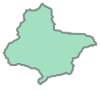

In [17]:
catchment_outline['geometry'][0]

In [18]:
snowmap_cloudfree_masked = snowmap_cloudfree.mask_polygon(catchment_outline['geometry'][0])

### Visualize one time step of the timeseries
Let's have a first look at a time slice of our snow map. So far we have not computed anything. We have only defined a set of functions that are going to be applied in sequence. This makes up our workflow or processing graph. 
To reduce the data volume which we are going to download we are only selecting one time step of our data cube.

**In order to start the processing we have to tell the cloud platform specifically that we want to execute our workflow. In this case we want to start the processing directly without registering a job on the backend. This solution is good for small amounts of data. For larger processing tasks batch jobs are preferred (we'll do that later).**

In [19]:
snowmap_cloudfree_1d = snowmap_cloudfree_masked.filter_temporal('2018-02-10', '2018-02-12')
snowmap_cloudfree_1d.download('31_results/snowmap_cloudfree_1d.nc')

Once the processing is done on the cloud and the data is downloaded we can load the file into our working environment and plot it!

The area of interest is spread across two S2 tiles. This is visibile in the northern part of the plot because we chose one specific acquisition date where there is not data available for the northern tile.

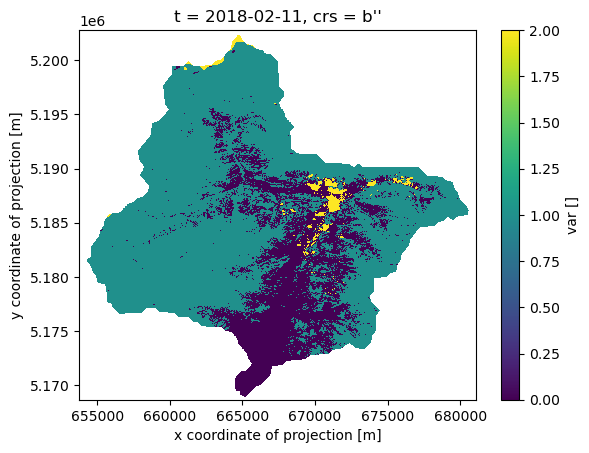

In [20]:
xr.open_dataarray('31_results/snowmap_cloudfree_1d.nc',decode_coords="all")[0].plot.imshow()

## Calculate Catchment Statistics

We are looking at the snow cover of a region over time and want to extract aggregated catchment statistics on snow cover and cloud cover. We do this by counting all the pixels in the catchment, counting the pixels that are covered by snow and the pixels covered by clouds.

Ultimately we are interested in the **snow covered area (SCA)** within the catchment. We count all snow covered pixels within the catchment for each time step. Multiplied by the pixel size that would be the snow covered area. The snow pixel count divided by the total number of pixels in the catchment is the percentage of pixels covered with snow. We will use this number.

We need to make sure that the information content meets our expected quality. Therefore, we calculate the **cloud percentage** for the catchment for each timestep. We use this information to filter the timeseries. All timesteps that have a cloud coverage of over 25% will be discarded.

We are going to 
- Get number of pixels in the catchment: total, clouds, snow.
- Combine the three aggregated pixel counts into one data cube.
- Calculate cloud and snow percentages
- Filter cloudy time steps with the cloud percentage
- Plot the resulting time series


**Quiz hint: remember the pixel counts here for the final exercise**

### Count pixels and aggregate spatially to the catchment

In [21]:
# number of all pixels
n_catchment = ((snowmap_cloudfree > -1) * 1.0).add_dimension(name="bands",type="bands",label="n_catchment")

# number of cloud pixels (no function needed, mask already created before)
n_cloud = cloud_mask.add_dimension(name="bands",type="bands",label="n_cloud")

# number of snow pixels
n_snow = ((snowmap_cloudfree == 1) * 1.0).add_dimension(name="bands",type="bands",label="n_snow")

# combine the binary data cubes into one data cube
n_catchment_cloud_snow = n_catchment.merge_cubes(n_cloud).merge_cubes(n_snow)

# aggregate to catchment
n_pixels = n_catchment_cloud_snow.aggregate_spatial(geometries = catchment_outline['geometry'][0], reducer = 'sum')
n_pixels

### Register a batch job for processing
We are starting the processing now with a batch job. This registers our job on the backend in our user space and assigns further information to the job, such as an ID, the job status, the process graph and further metadata. First we specifiy the end of our process graph with `save_result()` and specifiy the format (since we aggregated over the spatial dimension we will receive three arrays of data. So JSON is a suitable format). Then we create the batch job and start it.

In [22]:
# Define the end of the process graph and the output format
n_pixels_json = n_pixels.save_result(format="JSON")
# Create a batch job
job = n_pixels_json.create_job(title="n_pixels_json")
# start the job and wait till it finishes
job.start_and_wait()

0:00:00 Job 'j-2506271828344d9895b412d400fa7cc5': send 'start'
0:00:14 Job 'j-2506271828344d9895b412d400fa7cc5': created (progress 0%)
0:00:20 Job 'j-2506271828344d9895b412d400fa7cc5': created (progress 0%)
0:00:26 Job 'j-2506271828344d9895b412d400fa7cc5': created (progress 0%)
0:00:36 Job 'j-2506271828344d9895b412d400fa7cc5': queued (progress 0%)
0:00:46 Job 'j-2506271828344d9895b412d400fa7cc5': queued (progress 0%)
0:00:59 Job 'j-2506271828344d9895b412d400fa7cc5': queued (progress 0%)
0:01:14 Job 'j-2506271828344d9895b412d400fa7cc5': queued (progress 0%)
0:01:33 Job 'j-2506271828344d9895b412d400fa7cc5': running (progress N/A)
0:01:58 Job 'j-2506271828344d9895b412d400fa7cc5': running (progress N/A)
0:02:28 Job 'j-2506271828344d9895b412d400fa7cc5': running (progress N/A)
0:03:05 Job 'j-2506271828344d9895b412d400fa7cc5': running (progress N/A)
0:03:52 Job 'j-2506271828344d9895b412d400fa7cc5': running (progress N/A)
0:04:50 Job 'j-2506271828344d9895b412d400fa7cc5': running (progress N/A)

<BatchJob job_id='j-2506271828344d9895b412d400fa7cc5'>

Now we can check the status of our job. We can download the result once the job has finished.

In [23]:
job.status()

'finished'

In [24]:
if job.status() == "finished":
    results = job.get_results()
    results.download_files("31_results/")

**Quick hint: take a look at the job description: e.g. `job.describe_job()`**

### Load the resulting time series
Let's load the result. It contains the total number of pixels in the catchment, number of cloud and snow pixels.

In [25]:
# load the result
with open("31_results/timeseries.json","r") as file:
    n_pixels_json = json.load(file)

In [26]:
# check the first 5 entries to check the data structure.
list(n_pixels_json.items())[:3] # careful unsorted dates due to JSON format

[('2018-03-08T00:00:00Z', [[4201607, 153116, 3394572]]),
 ('2018-03-13T00:00:00Z', [[4201607, 2630053, 1546434]]),
 ('2018-03-23T00:00:00Z', [[4201607, 427904, 2603605]])]

In [27]:
len(n_pixels_json)

49

**_Quick hint: what is the length of the time series JSON?_**
`len(n_pixels_json)`

Now we do some data wrangling to get a structured data frame.

In [28]:
# Create a Pandas DataFrame to hold the values
dates = [k for k in n_pixels_json]
n_catchment_vals = [n_pixels_json[k][0][0] for k in n_pixels_json]
n_cloud_vals = [n_pixels_json[k][0][1] for k in n_pixels_json]
n_snow_vals = [n_pixels_json[k][0][2] for k in n_pixels_json]

data = {
        "time":pd.to_datetime(dates),
        "n_catchment_vals":n_catchment_vals,
        "n_cloud_vals":n_cloud_vals,
        "n_snow_vals":n_snow_vals
       }
df = pd.DataFrame(data=data).set_index("time")
# Sort the values by date
df = df.sort_values(axis=0,by="time")
df[:3]

,n_catchment_vals,n_cloud_vals,n_snow_vals
time,,,
2018-02-03 00:00:00+00:00,4166981,3859749,231920
2018-02-06 00:00:00+00:00,4201607,2552091,1553401
2018-02-08 00:00:00+00:00,4201607,165919,2991752


Compute the total number of snow pixels in the selected temporal period:

In [29]:
df.n_snow_vals.sum()

57184430

### Calculate the cloud percentage for filtering time steps
Divide the number of cloudy pixels by the number of total pixels = cloud percentage

In [30]:
perc_cloud = df["n_cloud_vals"].values / df["n_catchment_vals"].values * 100
df["perc_cloud"] = perc_cloud
df[:3]

,n_catchment_vals,n_cloud_vals,n_snow_vals,perc_cloud
time,,,,
2018-02-03 00:00:00+00:00,4166981,3859749,231920,92.626988
2018-02-06 00:00:00+00:00,4201607,2552091,1553401,60.740831
2018-02-08 00:00:00+00:00,4201607,165919,2991752,3.948941


**Quick hint: The sum of the n_catchment_vals should give an overall idea of the total number of pixels in the datacube for the whole time-series** `df.n_catchment_vals.sum()`

**Quick hint: a filter of the snow values can give an idea of when the maximum snow cover occurred** `df.where(df.n_snow_vals == df.n_snow_vals.max())`

**Quick hint: a simplified approach for converting from pixel count to square kilometres is to use this simplified formula::**

${{Area (km^2)} = (\frac{Spatial resolution (meters/pixel)^2}{1,000,000})\times{\text{Total pixel count}}}$

Plot the timeseries and the cloud threshold of 25%. If the cloud cover is higher the timestep will be excluded later on.

Plot the **cloud percentage** with the threshold.

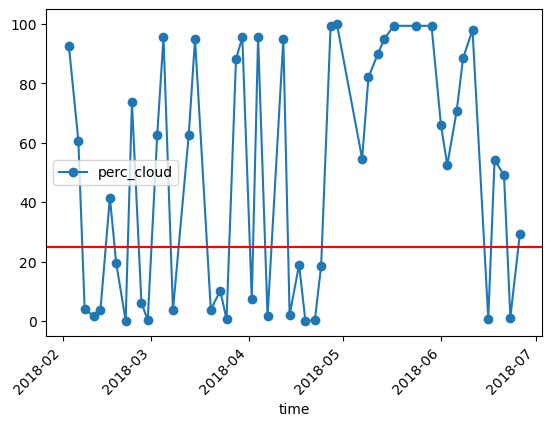

In [31]:
df.plot(y="perc_cloud",rot=45,kind="line",marker='o')
plt.axhline(y = 25, color = "r", linestyle = "-")
plt.show()

### Calculate the snow percentage
Divide the number of snow pixels by the number of total pixels = snow percentage

In [32]:
perc_snow = df["n_snow_vals"].values / df["n_catchment_vals"].values * 100
df["perc_snow"] = perc_snow
df[:3]

,n_catchment_vals,n_cloud_vals,n_snow_vals,perc_cloud,perc_snow
time,,,,,
2018-02-03 00:00:00+00:00,4166981,3859749,231920,92.626988,5.565660
2018-02-06 00:00:00+00:00,4201607,2552091,1553401,60.740831,36.971592
2018-02-08 00:00:00+00:00,4201607,165919,2991752,3.948941,71.204946


Plot the **unfiltered snow percentage**

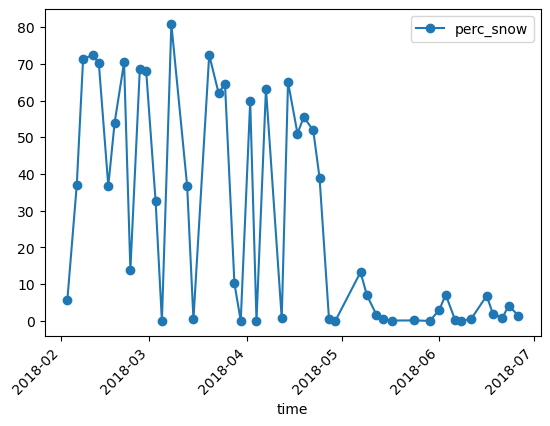

In [33]:
df.plot(y="perc_snow",rot=45,kind="line",marker='o')
plt.show()

### Filter out cloudy time steps
Keep only the dates with cloud coverage less than the threshold

In [34]:
df_filtered = df.loc[df["perc_cloud"]<25]

### Plot and save the cloud free snow percentage time series
Plot the **cloud filtered snow percentage**

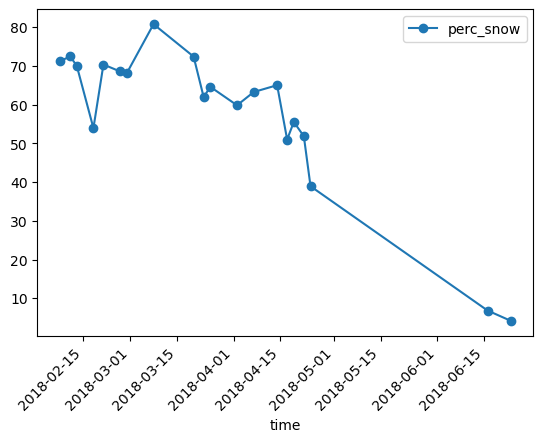

In [35]:
df_filtered.plot(y="perc_snow",rot=45,kind="line",marker='o')
plt.show()

Save the **cloud filtered snow percentage**

In [36]:
df_filtered.to_csv("31_results/filtered_snow_perc.csv")